In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil
import glob
import torch
from torchvision.models import vgg19
from PIL import Image
from torchvision import transforms
from torchvision.models.feature_extraction import create_feature_extractor
import torch.nn.functional as F

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device)

normalization_mean = [0.485, 0.456, 0.406]
normalization_std = [0.229, 0.224, 0.225]

resolution = (256,256)

loader  = transforms.Compose([transforms.ToTensor(), 
                                 transforms.Normalize(mean = normalization_mean, std = normalization_std),
                                 transforms.Resize(resolution[0]),
                                 transforms.CenterCrop(resolution)])

device='cpu'

In [10]:
def store_styles(folder):
    """
    Gets a list of styles and filenames from the folder (location)
    Param:
        folder: a location with format:
            >Bad
            >>images
            >Good
            >>class_1
            >>>images
            >>class_2
            >>>images
            ...
            where images = many files
    Returns:
        style_index: a list of styles
        result: a data dictionary where each filename is key, and the values is a list of 0/1 where 1 is the label for which the style is good
    """
    
    conflict_exception = False
    
    result = dict()

    good_folder = os.path.join(folder, "Good")
    #get all styles in the good folder
    styles = sorted(glob.glob(os.path.join(good_folder, "*")))
    
    #create list of styles which will help us associate a 1 at an index with a class
    #e.g. [1,1,1] is associated with good for "ACT-410", "AWA", "INS"
    #[0,0,1] is associated with good for "INS"
    #[0,0,0] is associated with bad style
    style_index = list()
    for style in styles:
        style_name = os.path.basename(style)
        style_index.append(style_name)
    
    #add good styles to our data
    for style in styles:
        style_name = os.path.basename(style)
        #get images in all styles:
        style_images = sorted(glob.glob(os.path.join(style, "*")))
        for style_image in style_images:
            
            #extract filename from path
            style_filename = os.path.basename(style_image)
            #if style filename is not already added to dictionary, create new dictionary entry
            if style_filename not in result:
                #create label list
                result[style_filename] = [0] * len(style_index)
            #set label of style index to 1
            result[style_filename][style_index.index(style_name)] += 1
    
    #add bad styles to our data
    bad_folder = os.path.join(folder, "Bad")
    #get all files in the folder of bad styles
    bad_images = sorted(glob.glob(os.path.join(bad_folder, "*")))
    
    for bad_image in bad_images:
        bad_style_filename = os.path.basename(bad_image)
        if bad_style_filename in result:
            print("Conflict found with image %s!" %bad_style_filename)
            conflict_exception=True
            
        result[bad_style_filename] = [0] * len(style_index)

    if conflict_exception:
        raise Exception("You can't have a bad style image which is also good!")
        return "BIG_ERROR"
        
    return style_index, result

In [11]:
style_folder = "/kaggle/input/goodbadstyles/GoodAndBadStyles"

style_index, result = store_styles(style_folder)

In [12]:
for data in result:
    print(data)
    print(result[data])
    break

0000218244_OG.jpeg
[1, 0, 0]


In [13]:
print(style_index)
print(result[list(result.keys())[0]])

#how many styles in each class
class_count = dict({"000" : 0, "001" : 0, "010" : 0, "011" : 0, "100" : 0, "101": 0, "110" : 0, "111" : 0})

for data in result.values():
    class_ = str(data[0]) + str(data[1]) + str(data[2])
    class_count[class_] = class_count[class_] + 1
    
print(class_count)

['ACT-410', 'AWA', 'INS']
[1, 0, 0]
{'000': 48, '001': 1, '010': 3, '011': 1, '100': 6, '101': 16, '110': 5, '111': 10}


In [14]:
pretrained_vgg = vgg19(pretrained=True)
torch.set_grad_enabled(False)
layers = [(name,module) for name, module in pretrained_vgg.named_modules()]
return_nodes = {
            #experiment 1-2
            layers[6][0]: "feature"
            #experiment 3 #conv1-1
            #layers[3][0]: "feature"
            #experiment 4 #conv2-1
            #layers[8][0]: "feature"
            #experiment 5 #pooling 2
            #layers[11][0]: "feature"
            #experiment 9 #pooling 3
            #layers[20][0]: "feature"
        }
intermediate_vgg = create_feature_extractor(pretrained_vgg, return_nodes=return_nodes)
    
def process_1(file_location):   
    img = image_loader(file_location)
    features = intermediate_vgg(img)
    return features['feature']

def process_2(file_location):
    """placeholder function"""
    return np.random.rand(1)

'''
def process_1(file_location):
    """features about texture using fourier transform (FFT)"""
    img = np.array(Image.open(file_location).convert('L'))    
    return np.log(np.abs(fft.fftshift(fft.fft2(img, s=(20,20)))) + 10e-10).flatten()

def process_2(file_location):
    """features about histogram"""    
    img_rgb = np.array(Image.open(file_location).convert('RGB'))
    img_hsv = np.array(Image.open(file_location).convert('HSV'))      
    return np.concatenate([np.mean(img_rgb, axis=(0, 1)), np.std(img_rgb, axis=(0, 1)), np.mean(img_hsv, axis=(0, 1)), np.std(img_hsv, axis=(0, 1))])
'''

def process_image(file_location):
    feature_0 = process_1(file_location)
    #feature_1 = process_2(file_location)
    return np.array(feature_0).flatten()

def process_dataset(style_index, file_dict, filenames, data_path):
    """
    Generates the train data for the given styles.
    Parameters:
        style_index: a list of styles to help identify which index of the list associated with a file belongs to a specific "working style";
                will be used to find the path of styles
        file_dict: a dictionary where the keys are all filenames and the values are a list which state the labels of the the filename
        filenames: a(n ordered) list of filenames, to ensure that the output will have the train data in the expected order
        data_path: path to the dataset in which folders ["Bad", "Good"] are found
    returns:
        X: a numpy array which is the train data for all the files in file_dict
    """
    X = []
    for filename in filenames:
        #get list of classes for current filename
        current_labels = file_dict[filename]
        try:
            #get the location for the first class for which the style is good
            #due to structure of data, good styles are found in "
            label_index = current_labels.index(1)
            
            style_class = style_index[label_index]
            
            current_class_location = os.path.join(data_path, "Good", style_class)
        except ValueError:
            #if not found, then the class is "bad style"
            current_class_location = os.path.join(data_path, "Bad")
        
        current_file_location = os.path.join(current_class_location, filename)
        X.append(process_image(current_file_location))
        
    return np.array(X)
        
        
    

In [15]:
print(layers[20])
#print(layers)

('features.18', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))


In [16]:
#get filenames into a sorted list
filenames = sorted(list(result.keys()))
#gets data from the filenames
X = process_dataset(style_index, result, filenames, style_folder)

Y = []
#get the true labels
for filename in filenames:
    #reminder: result is a dictionary where each filename has a label [int,int,int] associated with it
    #now we do binary classification so we only use one class
    if sum(result[filename])>0:
        Y.append(1)
    else:
        Y.append(0)
Y = np.array(Y)

from sklearn.model_selection import train_test_split
#do the train/test split
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=42)

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score

In [20]:
clf = SVC()
clf.fit(train_X, train_Y)
preds = clf.predict(test_X)
metric = balanced_accuracy_score(test_Y, preds)
print("Balanced accuracy score = %f" %metric)

Balanced accuracy score = 0.887500


In [43]:
def predict_styles(clf, folder):
    """
    Given a folder containing images, predict whether each style image is good or not.
    """
    #get a list of images
    predictions = []
    images = sorted(glob.glob(os.path.join(folder, "*")))
    for image in images:
        X = process_image(image).reshape(1, -1)
        prediction = clf.predict(X)
        predictions.append([image, prediction])
    return predictions

In [44]:
folder = "/kaggle/input/goodbadstyles/GoodAndBadStyles/Good/ACT-410"
predictions = predict_styles(clf, folder)

KeyboardInterrupt: 

In [42]:
print(predictions[0])
print(predictions[-3])

['/kaggle/input/goodbadstyles/GoodAndBadStyles/Good/ACT-410/0000218244_OG.jpeg', array([1])]
['/kaggle/input/goodbadstyles/GoodAndBadStyles/Good/ACT-410/skynews-florida-hurricane-nicole_5960570.jpg', array([1])]


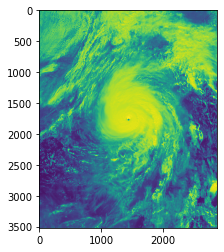

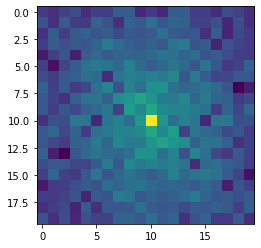

In [18]:
"""
#PREVIOUS EXPERIMENTS
from scipy import fft
import matplotlib.pyplot as plt
# Example of fft
img = np.array(Image.open("/kaggle/input/goodbadstyles/GoodAndBadStyles/Good/AWA/Michael_2018-10-10_1715Z_cropped.jpg").convert('L'))
fourier = np.log(np.abs(fft.fftshift(fft.fft2(img, s=(20,20)))))
plt.imshow(img)
plt.show()
plt.imshow(fourier)
"""
"""
#from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_validate

classifiers = [SVC()]
#svc is overfitting the best
#, KNeighborsClassifier(), GaussianProcessClassifier(), DecisionTreeClassifier(), GaussianNB()]

folds=5
for clf in classifiers:
    cv = cross_validate(clf, train_X, train_Y, cv=folds, scoring='balanced_accuracy')
    #predictions = clf.predict(test_X)
    #metric_performance = balanced_accuracy_score(test_Y, predictions)
    print(cv['test_score'])
    print("Average = %f" %(sum(cv['test_score'])/folds))
    
"""
"""
experiment 1: balanced accuracy, SVC model, resizing first to 128 then center cropping 128x128 resolution, first pool output (layer[6])
[0.6875     1.         0.70833333 0.85714286 0.78571429]
Average = 0.807738

>>BEST PERFORMER: experiment 2: same before, 256x256 resolution:
[0.9375     0.85714286 0.6875     0.85714286 0.78571429]
Average = 0.825000

experiment 3: same as experiment 2, but taking first relu output (relu_1_1) instead
[0.9375     0.79464286 0.6875     0.85714286 0.78571429]
Average = 0.812500

experiment 4: same as experiment 3, but taking relu_2_1 output instead
[0.8125     0.85714286 0.625      0.85714286 0.78571429]
Average = 0.787500

experiment 5: same as experiment 4, but taking maxpool(2) output instead
[0.75       1.         0.625      0.85714286 0.78571429]
Average = 0.803571

experiment 6: repeating experients 3, but with resolution 128 instead of 256
[0.9375     0.79464286 0.6875     0.85714286 0.78571429]
Average = 0.812500

experiment 7: experiment 4, but 128x128
[0.6875     0.85714286 0.625      0.85714286 0.78571429]
Average = 0.762500

experiment 8: experiment 5, but 128x128
[0.6875     1.         0.70833333 0.85714286 0.78571429]
Average = 0.807738

experiment 9: resolution 256x256, taking output from third pooling layer
[0.8125     0.86607143 0.70833333 0.78571429 0.85714286]
Average = 0.805952
""""""